In [700]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
import time
import matplotlib.pyplot as plt
import scipy
import os
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver


In [450]:
import pandas as pd
import pickle
with open("my_data.pkl", 'rb') as picklefile: 
    my_dict= pickle.load(picklefile)
with open("earnings_dates.pkl", 'rb') as picklefile: 
    dates= pickle.load(picklefile)
with open("filt.pkl", 'rb') as picklefile: 
    filt= pickle.load(picklefile)    

In [451]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp = pd.read_html(sp_url, header=0)[0][['Symbol','GICS Sector', 'GICS Sub Industry']]
sp.nunique()
sp_more = sp[sp['Symbol'].isin(my_dict.keys())]
sp_more.head()

Symbol             GICS Sector               GICS Sub Industry
0    MMM             Industrials        Industrial Conglomerates
1    ABT             Health Care           Health Care Equipment
2   ABBV             Health Care                 Pharmaceuticals
3   ABMD             Health Care           Health Care Equipment
4    ACN  Information Technology  IT Consulting & Other Services

In [452]:
my_dict_df = pd.DataFrame(my_dict.keys()).rename(columns = {0:'Symbol'})
my_dict_df['transcript'] = my_dict.values()
my_dict_df.head()

Symbol                                         transcript
0    MMM  uld now like to turn the call over to Bruce Je...
1    ABT   the exception of any participant's questions ...
2   ABBV  uld now like to introduce Ms. Liz Shea, Vice P...
3   ABMD  uld now like to introduce your host for today'...
4    ACN  uld now like to turn the conference over to ou...

In [453]:
my_dict_df['sector'] = sp_more['GICS Sector']
my_dict_df['subindustry'] = sp_more['GICS Sub Industry']
my_dict_df.nunique()

Symbol         481
transcript     481
sector          11
subindustry    125
dtype: int64

In [454]:
my_dict_df['sector'] = my_dict_df.sector.fillna('Not Available')

In [455]:
with open('my_dict_df.pkl', 'wb') as picklefile:
    pickle.dump(my_dict_df, picklefile)

In [456]:
train_df, test_df = train_test_split(my_dict_df, 
                                         stratify=my_dict_df.sector, 
                                         test_size=110, 
                                         random_state=42)
train_df.head()

Symbol                                         transcript  \
356    PNW  anie LaytonThank you, Christine. I would like ...   
54     AJG   of the comments made during this conference c...   
480    ZTS  presentation materials and additional financia...   
231    HST  Lingberg - Host Hotels & Resorts, Inc.Thanks, ...   
422   TWTR  uld now like to turn the call over to your hos...   

                     sector               subindustry  
356  Consumer Discretionary          Specialty Stores  
54   Information Technology  Communications Equipment  
480           Not Available                       NaN  
231                  Energy        Oil & Gas Drilling  
422             Industrials      Industrial Machinery

In [457]:
vectorizer = CountVectorizer(max_df=0.25, min_df=0.01,stop_words='english',ngram_range=(1,2))
doc_term_matrix = vectorizer.fit_transform(train_df['transcript'])
vocab_cnt = pd.Series(vectorizer.vocabulary_)
#vocab_cnt_adj = vocab_cnt.drop('uld')
vocab_cnt.sort_values(ascending=False).head()

zero based    7257
zero          7256
younger       7255
young         7254
york city     7253
dtype: int64

In [458]:
train_df.shape, test_df.shape

((371, 4), (110, 4))

In [459]:
pd.Series(test_df.sector).value_counts()

Industrials               15
Financials                14
Consumer Discretionary    14
Information Technology    14
Health Care               13
Real Estate                7
Consumer Staples           7
Energy                     6
Materials                  5
Not Available              5
Communication Services     5
Utilities                  5
Name: sector, dtype: int64

In [460]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

train_matrix = vectorizer.fit_transform(train_df.transcript)
words = vectorizer.get_feature_names()
train_matrix

<371x3268 sparse matrix of type '<class 'numpy.int64'>'
	with 51049 stored elements in Compressed Sparse Row format>

In [461]:
test_matrix = vectorizer.transform(test_df.transcript)
test_matrix

<110x3268 sparse matrix of type '<class 'numpy.int64'>'
	with 14919 stored elements in Compressed Sparse Row format>

In [462]:
n_components = 11
topic_labels = [f'Topic{i}' for i in range(1, n_components+1)]

In [463]:
lda_base = LatentDirichletAllocation(n_components=n_components,
                                     learning_method='online',
                                     max_iter=100)
lda_base.fit(train_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=11, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [464]:
joblib.dump(lda_base, 'lda_online_100iter.pkl')

['lda_online_100iter.pkl']

In [465]:
# pseudo counts: for each topic, expected count of each word
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]


(11, 3268)


array([[ 0.0909164 ,  0.09099338,  0.09091789, ...,  0.09093815,
         2.16146786,  0.09091398],
       [ 0.09097717,  0.09091679,  0.09091383, ...,  0.09091274,
         0.09091362,  0.09091398],
       [ 0.09091363,  9.96644871,  0.09091454, ...,  0.0909134 ,
         0.09091318,  0.09091544],
       [ 0.09091356,  0.09091836,  0.09091402, ...,  0.0909134 ,
         0.09091362,  0.09091483],
       [ 7.19462831, 77.95903977, 17.83045694, ...,  6.7064515 ,
         0.09093346,  5.88371952]])

In [466]:
lda_base.components_.shape

(11, 3268)

In [467]:
lda_base.transform(train_matrix).shape

(371, 11)

In [468]:
# normalize the count: dividing the count by sum of all the counts across 11 topics
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.tail()

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  Topic8  \
yields     0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
york       0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
young      0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
younger    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
zero       0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   

         Topic9  Topic10  Topic11  
yields     0.00     0.00     0.00  
york       0.00     0.00     0.00  
young      0.00     0.00     0.00  
younger    0.00     0.00     0.00  
zero       0.00     0.00     0.00

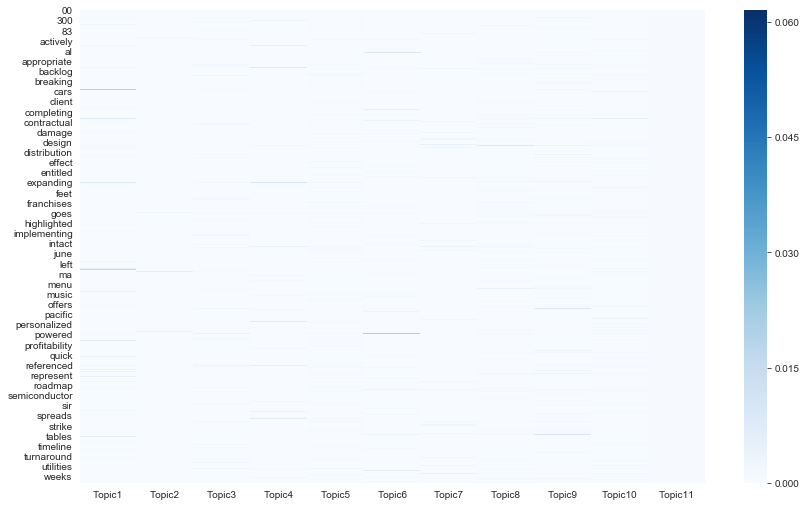

In [469]:
# for each topic, sum of prob of every word equals 1.
sns.heatmap(topics, cmap='Blues');

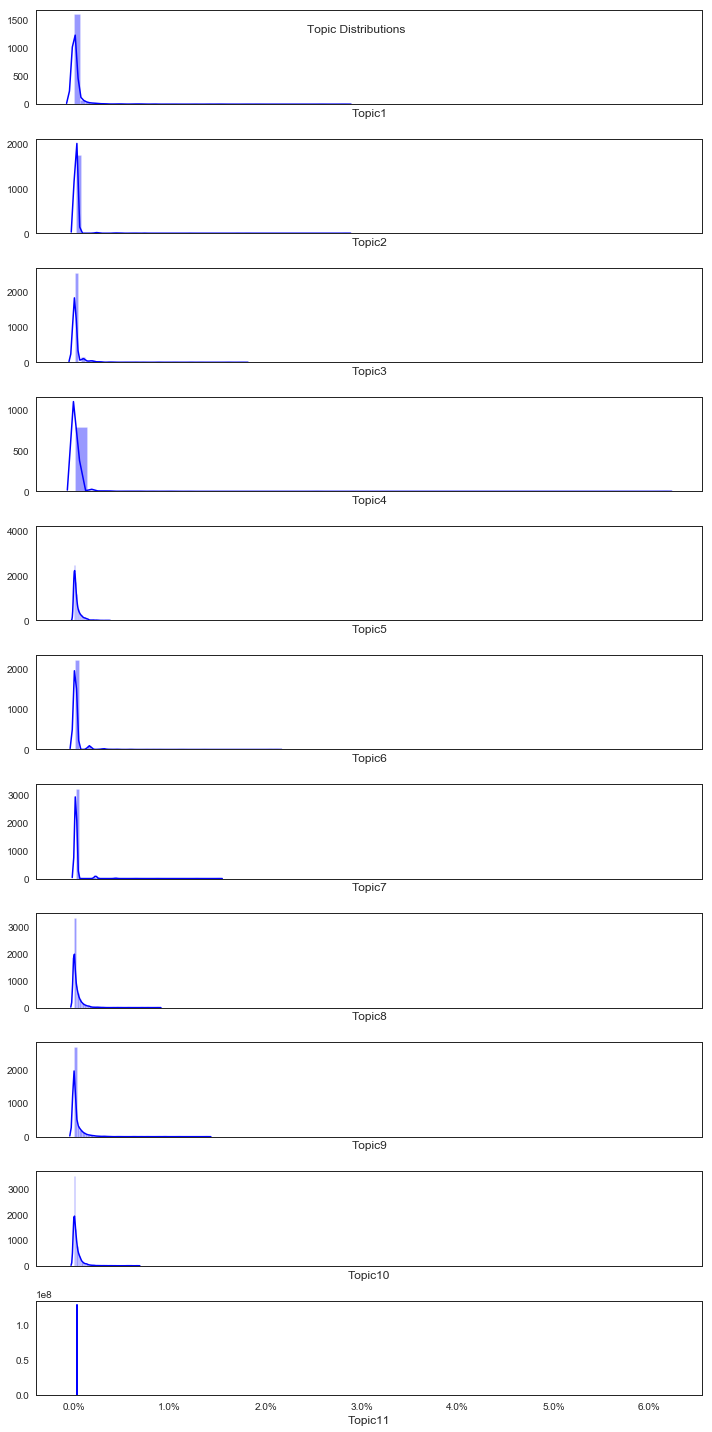

In [470]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=11,sharex=True, figsize=(10, 20))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i],color="b")
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

In [471]:
train_preds = lda_base.transform(train_matrix)
train_preds.shape

(371, 11)

In [472]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_df['sector'])
train_eval.head()

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  \
sector                                                                   
Consumer Discretionary    0.00    0.00    0.00    0.00    0.77    0.00   
Information Technology    0.99    0.00    0.00    0.00    0.00    0.00   
Not Available             0.00    0.00    0.00    0.00    0.00    0.00   
Energy                    0.00    0.00    0.00    0.00    0.80    0.00   
Industrials               0.00    0.00    0.00    0.00    0.12    0.00   

                        Topic7  Topic8  Topic9  Topic10  Topic11  
sector                                                            
Consumer Discretionary    0.00    0.00    0.00     0.23     0.00  
Information Technology    0.00    0.00    0.00     0.00     0.00  
Not Available             0.00    0.25    0.00     0.75     0.00  
Energy                    0.00    0.00    0.00     0.20     0.00  
Industrials               0.00    0.16    0.00     0.72     0.00

In [473]:
train_eval.groupby('sector').agg('mean')

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  \
sector                                                                   
Communication Services    0.00    0.00    0.00    0.00    0.53    0.00   
Consumer Discretionary    0.05    0.00    0.00    0.00    0.53    0.00   
Consumer Staples          0.03    0.00    0.06    0.00    0.52    0.00   
Energy                    0.02    0.00    0.00    0.00    0.49    0.00   
Financials                0.02    0.00    0.00    0.00    0.47    0.01   
Health Care               0.03    0.00    0.01    0.00    0.48    0.00   
Industrials               0.01    0.00    0.01    0.02    0.45    0.02   
Information Technology    0.03    0.00    0.03    0.00    0.45    0.00   
Materials                 0.04    0.00    0.00    0.00    0.47    0.00   
Not Available             0.04    0.00    0.05    0.00    0.29    0.00   
Real Estate               0.02    0.02    0.00    0.00    0.51    0.00   
Utilities                 0.01    0.00    0.02    0.00    0.49    0.00   

                        Topic7  Topic8  Topic9  Topic10  Topic11  
sector                                                            
Communication Services    0.00    0.16    0.03     0.27     0.00  
Consumer Discretionary    0.00    0.17    0.05     0.19     0.00  
Consumer Staples          0.00    0.08    0.09     0.21     0.00  
Energy                    0.00    0.16    0.08     0.25     0.00  
Financials                0.00    0.15    0.09     0.24     0.00  
Health Care               0.02    0.19    0.06     0.21     0.00  
Industrials               0.00    0.16    0.05     0.30     0.00  
Information Technology    0.00    0.21    0.08     0.20     0.00  
Materials                 0.00    0.08    0.05     0.36     0.00  
Not Available             0.00    0.19    0.03     0.39     0.00  
Real Estate               0.00    0.15    0.06     0.24     0.00  
Utilities                 0.00    0.08    0.08     0.31     0.00

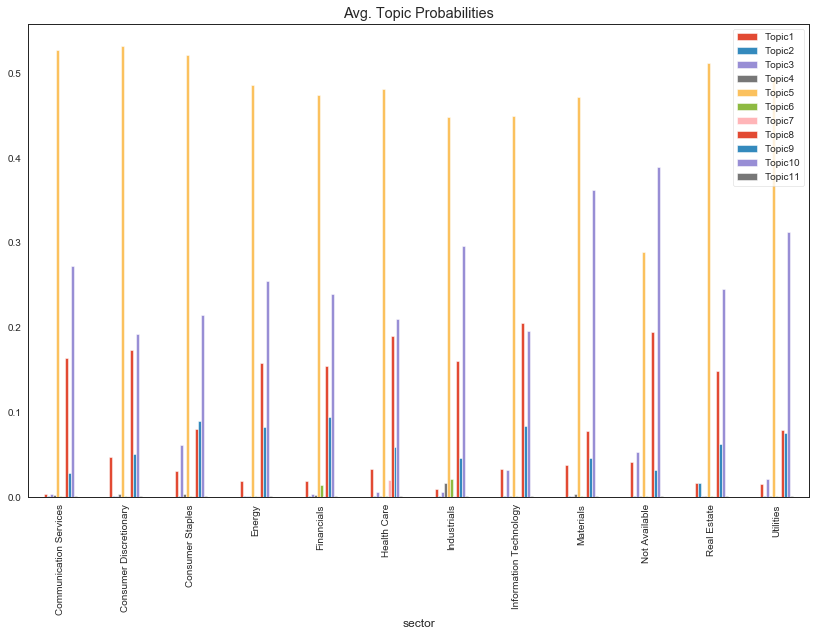

In [474]:
figsize=(5,5)
train_eval.groupby(level='sector').mean().plot.bar(title='Avg. Topic Probabilities')


sector
Communication Services     Topic5
Communication Services     Topic8
Communication Services     Topic8
Communication Services     Topic5
Communication Services    Topic10
dtype: object

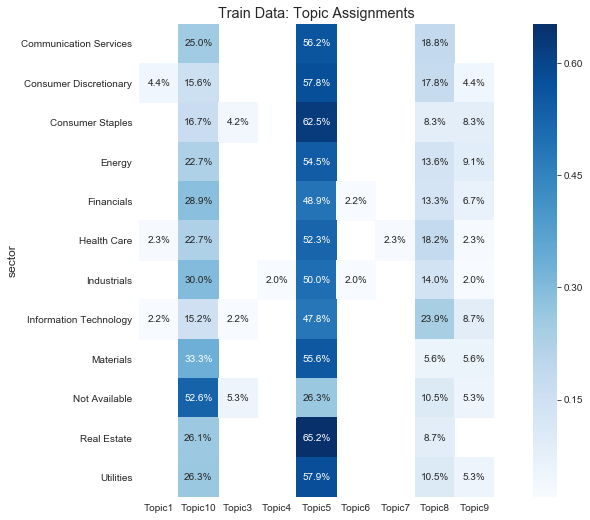

In [475]:
# Assign each document the topic label (from 1 to 11) with max prob
df = train_eval.groupby(level='sector').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='sector').value_counts(normalize=True).sort_values()
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');
df.head()

In [476]:
test_preds = lda_base.transform(test_matrix)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_df.sector)
test_eval.head()

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  \
sector                                                                   
Energy                    0.04    0.00    0.00    0.00    0.88    0.00   
Consumer Discretionary    0.28    0.00    0.00    0.01    0.46    0.00   
Real Estate               0.10    0.00    0.00    0.00    0.30    0.00   
Information Technology    0.06    0.00    0.02    0.00    0.41    0.00   
Industrials               0.00    0.00    0.00    0.00    0.44    0.00   

                        Topic7  Topic8  Topic9  Topic10  Topic11  
sector                                                            
Energy                    0.00    0.00    0.00     0.08     0.00  
Consumer Discretionary    0.00    0.12    0.00     0.12     0.00  
Real Estate               0.00    0.43    0.16     0.00     0.00  
Information Technology    0.00    0.20    0.03     0.29     0.00  
Industrials               0.00    0.08    0.06     0.42     0.00

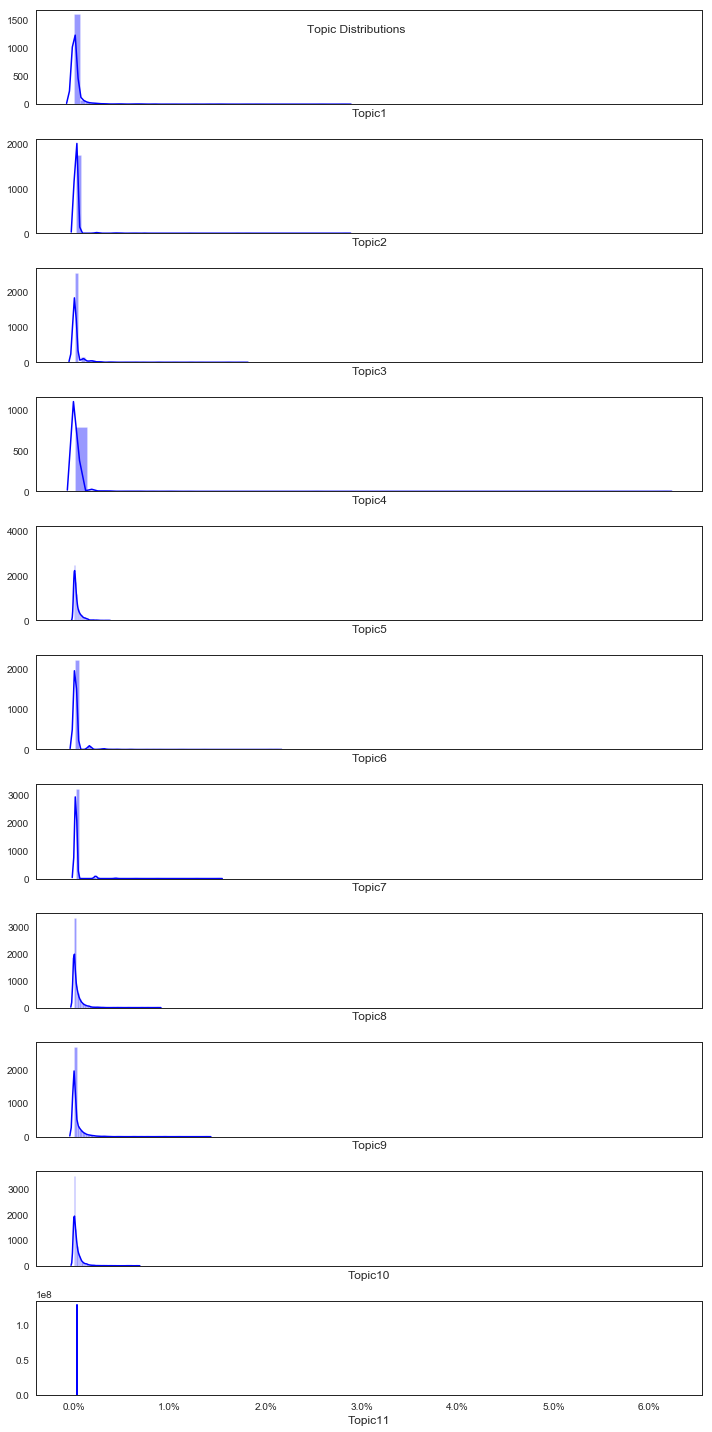

In [477]:


sns.set_style("white")
fig, axes = plt.subplots(nrows=11,sharex=True, figsize=(10, 20))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i],color="b")
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

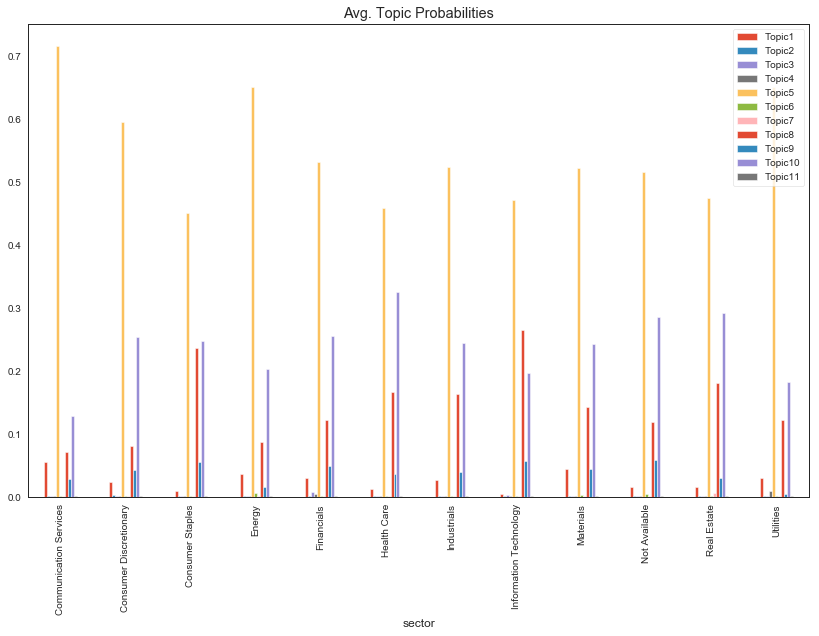

In [478]:
figsize=(5,5)
test_eval.groupby(level='sector').mean().plot.bar(title='Avg. Topic Probabilities')


sector
Communication Services    Topic5
Communication Services    Topic5
Communication Services    Topic5
Communication Services    Topic5
Communication Services    Topic5
dtype: object

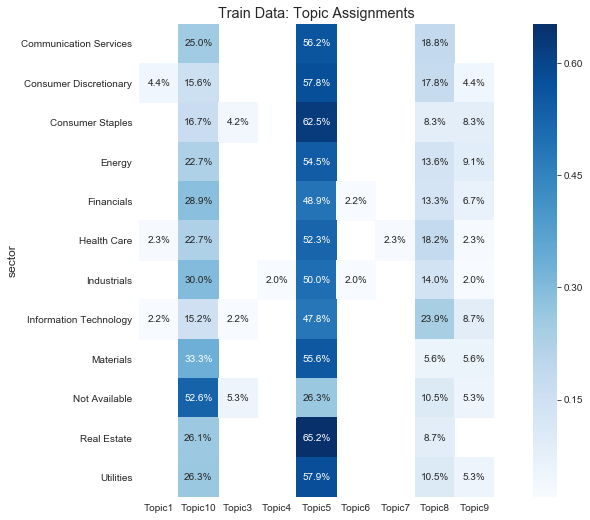

In [479]:
# Assign each document the topic label (from 1 to 11) with max prob
df2 = test_eval.groupby(level='sector').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='sector').value_counts(normalize=True).unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');
df2.head()

In [480]:
std_clf = make_pipeline(TruncatedSVD(n_components=2),MinMaxScaler(feature_range=(1,11)), LatentDirichletAllocation(n_components=11,
                                     learning_method='batch',
                                     max_iter=100))



In [481]:
pipe = std_clf.fit(train_matrix)
pipe

Pipeline(memory=None,
     steps=[('truncatedsvd', TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)), ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(1, 11))), ('latentdirichletallocation', LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             eva...        random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0))])

In [482]:
pipe.get_params()

{'memory': None,
 'steps': [('truncatedsvd',
   TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
          random_state=None, tol=0.0)),
  ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(1, 11))),
  ('latentdirichletallocation',
   LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                evaluate_every=-1, learning_decay=0.7,
                learning_method='batch', learning_offset=10.0,
                max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
                n_components=11, n_jobs=None, n_topics=None, perp_tol=0.1,
                random_state=None, topic_word_prior=None,
                total_samples=1000000.0, verbose=0))],
 'truncatedsvd': TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
        random_state=None, tol=0.0),
 'minmaxscaler': MinMaxScaler(copy=True, feature_range=(1, 11)),
 'latentdirichletallocation': LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
              evaluate

In [483]:
test_preds_svd = pipe.transform(test_matrix)

In [484]:
train_preds_svd = pipe.transform(train_matrix)

In [485]:
joblib.dump(pipe, 'lda_svd_minmax.pkl')

['lda_svd_minmax.pkl']

In [486]:
print(train_preds_svd.shape, test_preds_svd.shape)

(371, 11) (110, 11)


In [487]:
train_svd_eval = pd.DataFrame(train_preds_svd, columns=topic_labels, index=train_df.sector)
train_svd_eval.head()

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  \
sector                                                                   
Consumer Discretionary    0.01    0.01    0.01    0.01    0.01    0.01   
Information Technology    0.01    0.01    0.01    0.01    0.01    0.01   
Not Available             0.01    0.01    0.01    0.01    0.01    0.01   
Energy                    0.01    0.01    0.01    0.01    0.01    0.01   
Industrials               0.01    0.01    0.01    0.01    0.01    0.01   

                        Topic7  Topic8  Topic9  Topic10  Topic11  
sector                                                            
Consumer Discretionary    0.91    0.01    0.01     0.01     0.01  
Information Technology    0.01    0.01    0.01     0.01     0.91  
Not Available             0.88    0.01    0.01     0.01     0.01  
Energy                    0.01    0.01    0.01     0.01     0.91  
Industrials               0.88    0.01    0.01     0.01     0.01

In [488]:
train_svd_eval.groupby('sector').agg('mean')

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  \
sector                                                                   
Communication Services    0.02    0.02    0.02    0.02    0.02    0.02   
Consumer Discretionary    0.02    0.02    0.02    0.02    0.02    0.02   
Consumer Staples          0.01    0.01    0.01    0.01    0.01    0.01   
Energy                    0.02    0.02    0.02    0.02    0.02    0.02   
Financials                0.02    0.02    0.02    0.02    0.02    0.02   
Health Care               0.01    0.01    0.01    0.01    0.01    0.01   
Industrials               0.02    0.02    0.02    0.02    0.02    0.02   
Information Technology    0.02    0.02    0.02    0.02    0.02    0.02   
Materials                 0.01    0.01    0.01    0.01    0.01    0.01   
Not Available             0.02    0.02    0.02    0.02    0.02    0.02   
Real Estate               0.02    0.02    0.02    0.02    0.02    0.02   
Utilities                 0.02    0.02    0.02    0.02    0.02    0.02   

                        Topic7  Topic8  Topic9  Topic10  Topic11  
sector                                                            
Communication Services    0.52    0.02    0.01     0.02     0.30  
Consumer Discretionary    0.45    0.02    0.01     0.02     0.42  
Consumer Staples          0.64    0.01    0.01     0.01     0.24  
Energy                    0.51    0.02    0.01     0.02     0.31  
Financials                0.41    0.02    0.01     0.02     0.42  
Health Care               0.42    0.01    0.01     0.01     0.48  
Industrials               0.50    0.02    0.01     0.02     0.36  
Information Technology    0.54    0.02    0.01     0.02     0.33  
Materials                 0.46    0.01    0.01     0.01     0.41  
Not Available             0.35    0.02    0.01     0.02     0.49  
Real Estate               0.56    0.02    0.01     0.02     0.26  
Utilities                 0.44    0.02    0.01     0.02     0.40

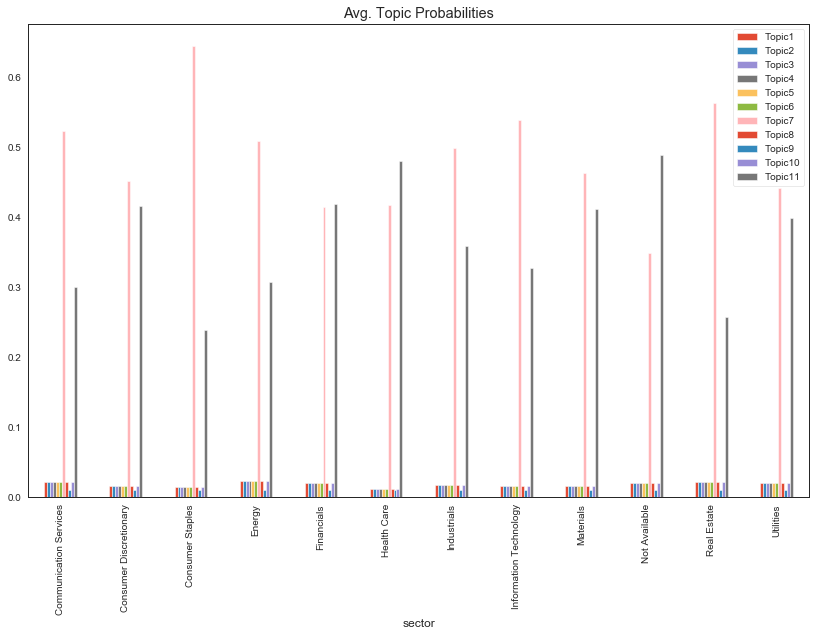

In [489]:
figsize=(5,5)
train_svd_eval.groupby(level='sector').mean().plot.bar(title='Avg. Topic Probabilities')


sector
Communication Services     Topic5
Communication Services     Topic8
Communication Services     Topic8
Communication Services     Topic5
Communication Services    Topic10
dtype: object

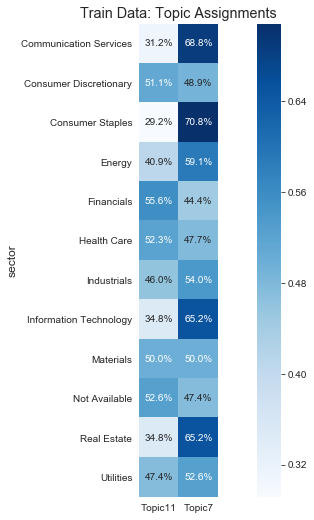

In [490]:
# Assign each document the topic label (from 1 to 11) with max prob
df3 = train_svd_eval.groupby(level='sector').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df3.groupby(level='sector').value_counts(normalize=True).sort_values()
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');
df.head()

In [497]:
test_svd_eval = pd.DataFrame(test_preds_svd, columns=topic_labels, index=test_df.sector)
test_svd_eval.head()

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  \
sector                                                                   
Energy                    0.01    0.01    0.01    0.01    0.01    0.01   
Consumer Discretionary    0.10    0.10    0.10    0.10    0.10    0.10   
Real Estate               0.01    0.01    0.01    0.01    0.01    0.01   
Information Technology    0.10    0.10    0.10    0.10    0.10    0.10   
Industrials               0.01    0.01    0.01    0.01    0.01    0.01   

                        Topic7  Topic8  Topic9  Topic10  Topic11  
sector                                                            
Energy                    0.01    0.01    0.01     0.01     0.93  
Consumer Discretionary    0.10    0.10    0.01     0.10     0.10  
Real Estate               0.01    0.01    0.01     0.01     0.90  
Information Technology    0.10    0.10    0.01     0.10     0.10  
Industrials               0.01    0.01    0.01     0.01     0.90

sector
Communication Services     Topic5
Communication Services     Topic8
Communication Services     Topic8
Communication Services     Topic5
Communication Services    Topic10
dtype: object

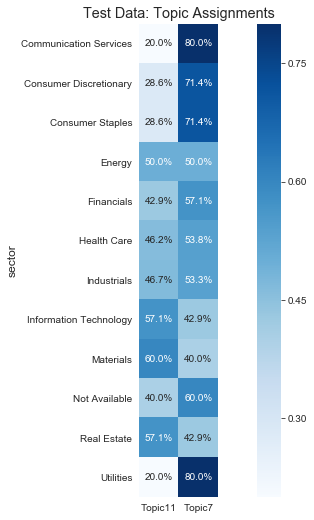

In [498]:
# Assign each document the topic label (from 1 to 11) with max prob
df4 = test_svd_eval.groupby(level='sector').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df4.groupby(level='sector').value_counts(normalize=True).sort_values()
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Test Data: Topic Assignments');
df.head()

In [492]:
train_df['lda_base'] = df.values

In [493]:
test_df['lda_base'] = df2.values

In [494]:
train_df['lda_svd'] = df3.values

In [499]:
test_df['lda_svd'] = df4.values

In [600]:
train_df.head()

Symbol                                         transcript  \
356    PNW  anie LaytonThank you, Christine. I would like ...   
54     AJG   of the comments made during this conference c...   
480    ZTS  presentation materials and additional financia...   
231    HST  Lingberg - Host Hotels & Resorts, Inc.Thanks, ...   
422   TWTR  uld now like to turn the call over to your hos...   

                     sector               subindustry lda_base  lda_svd  
356  Consumer Discretionary          Specialty Stores   Topic5   Topic7  
54   Information Technology  Communications Equipment   Topic8  Topic11  
480           Not Available                       NaN   Topic8  Topic11  
231                  Energy        Oil & Gas Drilling   Topic5   Topic7  
422             Industrials      Industrial Machinery  Topic10  Topic11

In [1105]:
norm = np.linalg.norm(np.array([x for x in range(1,12)]))
mapper ={}
for i in range(11):
    exec(f'mapper["Topic{i+1}"]=i/norm')
mapper

{'Topic1': 0.0,
 'Topic2': 0.044455422447438706,
 'Topic3': 0.08891084489487741,
 'Topic4': 0.1333662673423161,
 'Topic5': 0.17782168978975482,
 'Topic6': 0.2222771122371935,
 'Topic7': 0.2667325346846322,
 'Topic8': 0.3111879571320709,
 'Topic9': 0.35564337957950964,
 'Topic10': 0.40009880202694836,
 'Topic11': 0.444554224474387}

In [595]:
train_matrix_base_aug = scipy.sparse.hstack((train_matrix,  df.replace(mapper).astype(float).values.reshape(-1,1)))
train_matrix_base_aug.shape

(371, 3269)

In [596]:
test_matrix_base_aug = scipy.sparse.hstack((test_matrix, df2.replace(mapper).astype(float).values.reshape(-1,1)))
test_matrix_base_aug.shape

(110, 3269)

In [598]:
train_matrix_svd_aug = scipy.sparse.hstack((train_matrix, df3.replace(mapper).astype(float).values.reshape(-1,1)))
train_matrix_base_aug.shape

(371, 3269)

In [599]:
test_matrix_svd_aug = scipy.sparse.hstack((test_matrix, df4.replace(mapper).astype(float).values.reshape(-1,1)))
test_matrix_base_aug.shape

(110, 3269)

# Let's now import stock price data

In [614]:
url = f'https://api.iextrading.com/1.0/stock/{list(my_dict.keys())[0]}/chart/1y'
price_df = pd.read_json(url)[['date','close']].rename(columns = {'close':list(my_dict.keys())[0]})
for symbol in list(my_dict.keys())[1:]:
    url= f'https://api.iextrading.com/1.0/stock/{symbol}/chart/1y'
    price_df = price_df.merge(pd.read_json(url)[['date','close']].rename(columns = {'close':symbol}), on='date',how='outer')
price_df.head()

date    MMM   ABT  ABBV   ABMD    ACN  ATVI   ADBE   AMD    AAP  ...  \
0 2018-04-17 214.19 58.77 89.37 304.43 151.59 67.74 231.16 10.52 108.03  ...   
1 2018-04-18 213.63 58.50 90.06 307.63 152.85 68.14 231.10 10.36 107.23  ...   
2 2018-04-19 212.98 58.85 88.81 306.45 151.93 67.14 227.62 10.11 105.02  ...   
3 2018-04-20 211.91 58.17 88.42 305.92 149.79 65.77 225.24  9.99 103.60  ...   
4 2018-04-23 210.09 57.83 88.97 302.65 150.41 65.70 225.30 10.04 105.36  ...   

    WLTW   WYNN   XEL   XRX  XLNX   XYL   YUM    ZBH  ZION   ZTS  
0 150.52 186.45 44.19 28.80 68.67 77.92 85.12 107.92 50.80 84.99  
1 150.25 188.66 43.91 29.08 66.82 78.26 85.50 109.17 50.95 85.29  
2 150.28 187.43 43.97 29.13 63.77 77.80 84.96 109.83 52.06 84.86  
3 149.02 188.27 43.69 30.30 63.03 78.31 84.82 109.41 52.63 84.90  
4 148.67 188.98 43.90 29.97 62.60 77.56 84.42 110.32 53.09 84.75  

[5 rows x 482 columns]

In [625]:

from collections import defaultdict
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

dates = defaultdict(str)
cnt=0
captcha=[]
captcha2=[]

for symbol in my_dict.keys():
    url_path = f'https://www.nasdaq.com/symbol/{symbol}/call-transcripts'
    response = requests.get(url_path)
    soup = BeautifulSoup(response.text,'lxml')
    query = re.compile('Q3 2018')
    if not soup.find(text=query): 
        print(1)
        # If page is dynamically loading from javascript, I couldn't locate href. Then, use selenium
        # to obtain rendered page
        alter_url=f'https://seekingalpha.com/symbol/{symbol}/earnings/transcripts'
    #         driver = webdriver.Chrome(chromedriver)
    #         driver.get(url_path)
    #         soup = BeautifulSoup(driver.page_source,'lxml')
    #         soup.find_all('a')
        response = requests.get(alter_url)
        soup = BeautifulSoup(response.text,'lxml')
        if soup.find(text=re.compile('captcha')) != None:
            captcha.append(symbol)
            print('captcha1')
        aug_path = soup.find(text=query).find_parent()['href']
        call_url = f'https://seekingalpha.com'+aug_path
        call_response = requests.get(call_url)
        soup = BeautifulSoup(call_response.text,'lxml')
        if soup.find(text=re.compile('captcha')) != None:
            captcha2.append(symbol)
            print('captcha2')
        raw_transcript = [item.text for item in soup.find(text=query).find_parent().find_parent().find_parent().find_all('p')]
        raw_transcript=raw_transcript[raw_transcript.index('')+1:]
        raw_transcript=''.join(raw_transcript)
    else:
        unrefined_string = soup.find(text=query).find_parents('span')
        aug_path = unrefined_string[0].find('a')['href']
        call_url = f'http://www.nasdaq.com'+aug_path

        call_response = requests.get(call_url)
        soup = BeautifulSoup(call_response.text,'lxml')
        raw_transcript = [item.text for item in soup.find(text=query).find_parent().find_parent().find_parent().find_all('p')]
        raw_transcript=''.join(raw_transcript)
        Months = ['January', 'February','March', 'April','May','June','July','August','September','October','November','December']
        month_cand = []
        for month in Months:
            idx = raw_transcript.find(month)
            if idx > 0:
                month_cand.append(idx)
        idx = min(month_cand)
        idx2 = raw_transcript[idx:].find(' ')
        idx3 = raw_transcript[idx+idx2 +1:].find(' ')
        idx4 = raw_transcript[idx+idx2+idx3 +2:].find(' ')
        exec("dates[f'{symbol}'] = raw_transcript[idx:idx+idx2+idx3+idx4+2]")
dates



defaultdict(str,
            {'MMM': 'October 23, 2018',
             'ABT': 'October 17, 2018',
             'ABBV': 'November 02, 2018',
             'ABMD': 'February 01, 2018',
             'ACN': 'June 28 2018',
             'ATVI': 'November 08, 2018',
             'ADBE': 'September 13, 2018,',
             'AMD': 'October 24, 2018',
             'AAP': 'November 13, 2018',
             'AES': 'November 6, 2018',
             'AMG': 'October 29, 2018,',
             'AFL': 'October 25, 2018',
             'A': 'August 14, 2018,',
             'APD': 'July 26, 2018',
             'AKAM': 'October 29, 2018',
             'ALK': 'October 25, 2018',
             'ALB': 'November 08, 2018',
             'ARE': 'October 30, 2018',
             'ALXN': 'October 24, 2018',
             'ALGN': 'October 24, 2018',
             'ALLE': 'October 25, 2018',
             'AGN': 'October 30, 2018',
             'ADS': 'October 18, 2018',
             'LNT': 'November 07, 2018,',
             

In [626]:
earnings_dates =pd.to_datetime(pd.Series(dates))
earnings_dates.head()

MMM    2018-10-23
ABT    2018-10-17
ABBV   2018-11-02
ABMD   2018-02-01
ACN    2018-06-28
dtype: datetime64[ns]

In [660]:
# filter for post transcript stock prices
filt = (price_df['date'] - earnings_dates[price_df.columns[1]]>pd.Timedelta(0))
for symbol in price_df.columns[2:]:
    if my_dict[symbol] != '':
        filt = pd.concat([filt,(price_df['date'] - earnings_dates[symbol]>pd.Timedelta(0))], axis=1)
    else:
        filt[symbol] = False
filt.columns = price_df.columns[1:]
price_cumul = price_df.loc[:,'MMM':'ZTS']
price_cumul=price_cumul[filt] 
price_cumul.index = price_df['date']
price_cumul

MMM   ABT  ABBV   ABMD    ACN  ATVI   ADBE   AMD    AAP   AES  \
date                                                                          
2018-04-17    nan   nan   nan 304.43    nan   nan    nan   nan    nan   nan   
2018-04-18    nan   nan   nan 307.63    nan   nan    nan   nan    nan   nan   
2018-04-19    nan   nan   nan 306.45    nan   nan    nan   nan    nan   nan   
2018-04-20    nan   nan   nan 305.92    nan   nan    nan   nan    nan   nan   
2018-04-23    nan   nan   nan 302.65    nan   nan    nan   nan    nan   nan   
2018-04-24    nan   nan   nan 290.93    nan   nan    nan   nan    nan   nan   
2018-04-25    nan   nan   nan 293.20    nan   nan    nan   nan    nan   nan   
2018-04-26    nan   nan   nan 303.41    nan   nan    nan   nan    nan   nan   
2018-04-27    nan   nan   nan 301.74    nan   nan    nan   nan    nan   nan   
2018-04-30    nan   nan   nan 300.95    nan   nan    nan   nan    nan   nan   
2018-05-01    nan   nan   nan 310.50    nan   nan    nan   nan    nan   nan   
2018-05-02    nan   nan   nan 302.14    nan   nan    nan   nan    nan   nan   
2018-05-03    nan   nan   nan 335.57    nan   nan    nan   nan    nan   nan   
2018-05-04    nan   nan   nan 349.28    nan   nan    nan   nan    nan   nan   
2018-05-07    nan   nan   nan 347.57    nan   nan    nan   nan    nan   nan   
2018-05-08    nan   nan   nan 347.38    nan   nan    nan   nan    nan   nan   
2018-05-09    nan   nan   nan 358.16    nan   nan    nan   nan    nan   nan   
2018-05-10    nan   nan   nan 368.88    nan   nan    nan   nan    nan   nan   
2018-05-11    nan   nan   nan 372.68    nan   nan    nan   nan    nan   nan   
2018-05-14    nan   nan   nan 375.67    nan   nan    nan   nan    nan   nan   
2018-05-15    nan   nan   nan 380.35    nan   nan    nan   nan    nan   nan   
2018-05-16    nan   nan   nan 381.97    nan   nan    nan   nan    nan   nan   
2018-05-17    nan   nan   nan 379.94    nan   nan    nan   nan    nan   nan   
2018-05-18    nan   nan   nan 384.36    nan   nan    nan   nan    nan   nan   
2018-05-21    nan   nan   nan 379.17    nan   nan    nan   nan    nan   nan   
2018-05-22    nan   nan   nan 386.35    nan   nan    nan   nan    nan   nan   
2018-05-23    nan   nan   nan 395.52    nan   nan    nan   nan    nan   nan   
2018-05-24    nan   nan   nan 394.46    nan   nan    nan   nan    nan   nan   
2018-05-25    nan   nan   nan 394.28    nan   nan    nan   nan    nan   nan   
2018-05-29    nan   nan   nan 387.40    nan   nan    nan   nan    nan   nan   
...           ...   ...   ...    ...    ...   ...    ...   ...    ...   ...   
2019-03-07 199.86 76.49 77.22 317.42 160.52 41.09 255.46 22.08 154.07 17.67   
2019-03-08 200.89 76.32 76.56 314.21 160.36 41.70 254.74 22.01 151.71 17.70   
2019-03-11 207.10 77.49 77.06 319.20 162.59 42.58 260.96 22.96 155.40 17.97   
2019-03-12 205.80 77.92 77.71 323.76 162.64 42.29 263.51 23.49 154.81 18.12   
2019-03-13 206.66 78.30 77.90 325.63 162.76 43.35 264.38 23.38 154.64 18.12   
2019-03-14 207.38 78.66 78.90 325.61 163.47 42.97 267.69 22.82 153.94 18.18   
2019-03-15 208.08 79.53 80.28 333.23 165.02 44.27 257.09 23.29 154.78 18.31   
2019-03-18 208.49 78.51 79.59 333.25 165.06 44.61 257.76 23.25 161.51 18.15   
2019-03-19 209.02 79.63 79.76 339.36 164.83 46.05 260.42 26.00 163.36 17.84   
2019-03-20 208.30 79.61 79.38 339.66 164.90 45.79 259.74 25.70 164.09 17.93   
2019-03-21 209.61 79.73 80.18 337.43 166.86 48.21 264.18 27.89 169.07 18.28   
2019-03-22 204.66 77.65 78.72 323.21 163.88 46.50 259.69 26.37 164.84 18.06   
2019-03-25 203.21 77.91 78.47 313.22 163.72 46.61 262.27 25.97 167.78 18.24   
2019-03-26 207.24 78.68 79.70 286.00 165.57 46.06 265.59 25.69 168.27 18.41   
2019-03-27 207.16 78.41 78.84 276.39 165.10 45.52 262.34 24.89 166.89 18.25   
2019-03-28 208.53 79.12 78.91 283.90 173.68 45.62 263.53 25.06 168.75 18.11   
2019-03-29 207.78 79.61 79.54 285.59 174.57 45.53 266.49 25.52 170.53 18.08   
2019-04-01 211.94 79.34 79.72 277.76 174.87 47.12 272.17 26.36 1

In [815]:
# 1-day holding period return from the announcement date
r= []
for symbol in price_df.columns[1:]:
    if price_cumul[symbol].notna().any():
        r+=[(price_cumul[symbol][price_cumul[symbol].notna()][1]/price_cumul[symbol]\
        [price_cumul[symbol].notna()][0] -1)]
r

[0.0024386116998427187,
 -0.008071177959703468,
 0.013077553656597685,
 0.010511447623427372,
 -0.002200568988273255,
 -0.020358574789817396,
 -0.023444610287960965,
 -0.08510638297872342,
 0.007710079821207749,
 0.004486305133393209,
 -0.013110674525212862,
 0.013908458816653368,
 0.011895338439407599,
 -6.197800919038876e-05,
 -0.004135079255685681,
 -0.007647184475591207,
 -0.04209773835675645,
 0.0004909783761823938,
 -0.0075964493001023925,
 -0.008359546688499142,
 -0.012574334936326093,
 0.040820199312113115,
 -0.03802406165414807,
 0.01779679538056289,
 0.009379944162700271,
 -0.047962145463708694,
 0.02377687748101387,
 -0.06326355451939047,
 -0.011500896071458988,
 0.004315017997311266,
 0.017871757028042223,
 -0.020800584591593174,
 0.019639788530701585,
 -0.017906124452103045,
 0.009498889927755716,
 -0.03320390658774641,
 0.014449973398429128,
 0.012116555515326866,
 0.0005705737635024466,
 -0.010807186568811744,
 -0.03007688160528199,
 0.01427238368304451,
 -0.040817556975

In [816]:
r_train, r_test = train_test_split(r, stratify=my_dict_df.sector, 
                                    test_size=110,random_state=42)


Analyze base model

In [826]:


alpha = 1
sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
model1 = sparse_lasso.fit(train_matrix_base_aug, r_train)


In [869]:
model1.predict(test_matrix_base_aug)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

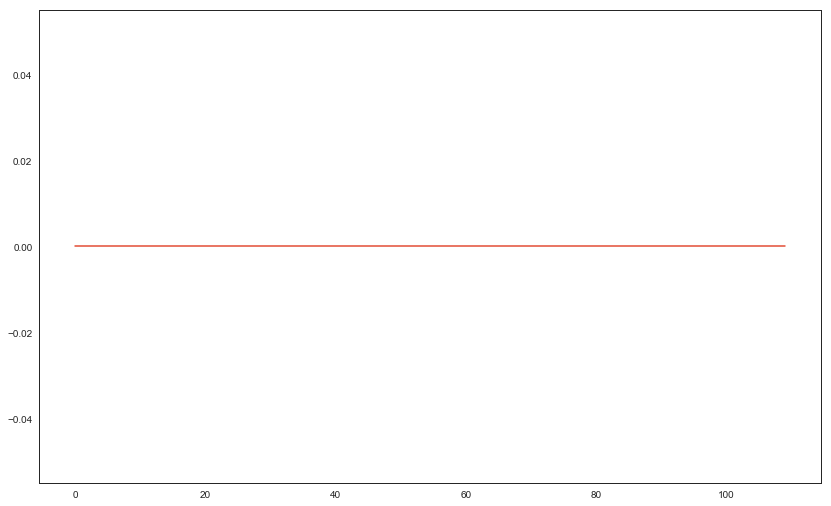

In [880]:
sns.lineplot(y=model1.predict(test_matrix_base_aug),x=range(len(model1.predict(test_matrix_base_aug))))

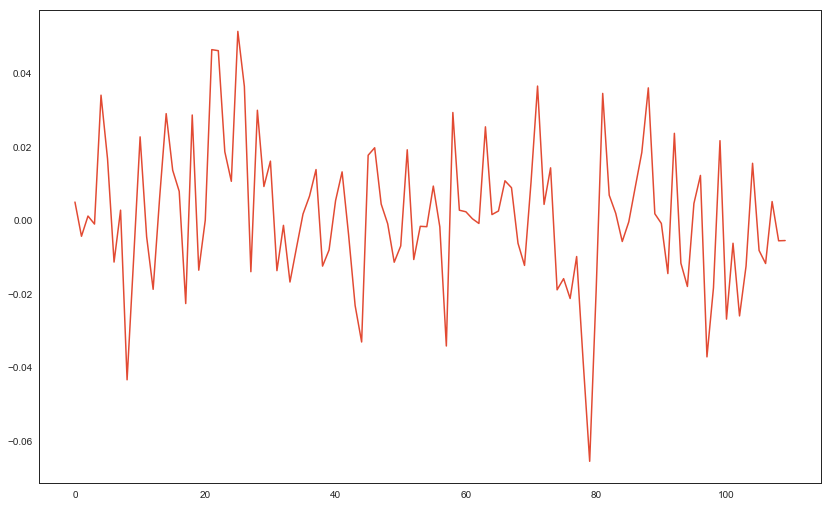

In [849]:
sns.lineplot(y=r_test,x=range(len(model1.predict(test_matrix_base_aug))))

In [836]:
print(model1.score(train_matrix_base_aug,r_train), model1.score(test_matrix_base_aug,r_test))

-0.0032813561826900983 -0.003237061441683009


In [829]:
alpha = 1
sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
model2 = sparse_lasso.fit(train_matrix_svd_aug, r_train)

In [837]:
print(model2.score(train_matrix_svd_aug,r_train), model2.score(test_matrix_svd_aug,r_test))

-0.0032813561826900983 -0.003237061441683009


In [858]:
linmodel_base = LinearRegression().fit(df.replace(mapper).astype(float).values.reshape(-1,1), r_train)

linmodel_base.score(df.replace(mapper).astype(float).values.reshape(-1,1), r_train)

0.002698880503897993

In [859]:
linmodel_base.score(df2.replace(mapper).astype(float).values.reshape(-1,1), r_test)

-0.009044594462848332

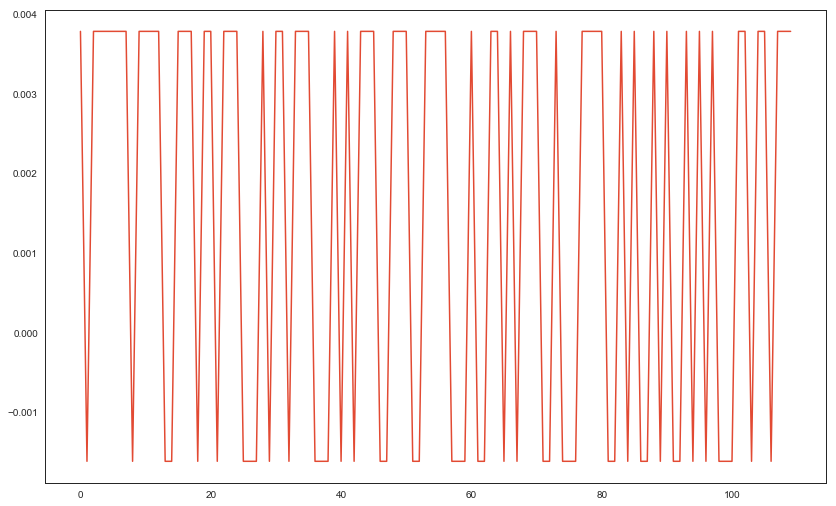

In [860]:
pred_base = linmodel.predict(df2.replace(mapper).astype(float).values.reshape(-1,1))
sns.lineplot(y=pred, x=range(len(pred)))

In [838]:
linmodel = LinearRegression().fit(df3.replace(mapper).astype(float).values.reshape(-1,1), r_train)

linmodel.score(df3.replace(mapper).astype(float).values.reshape(-1,1), r_train)

0.013040783531999889

In [839]:
linmodel.score(df4.replace(mapper).astype(float).values.reshape(-1,1), r_test)

-0.05569731506420594

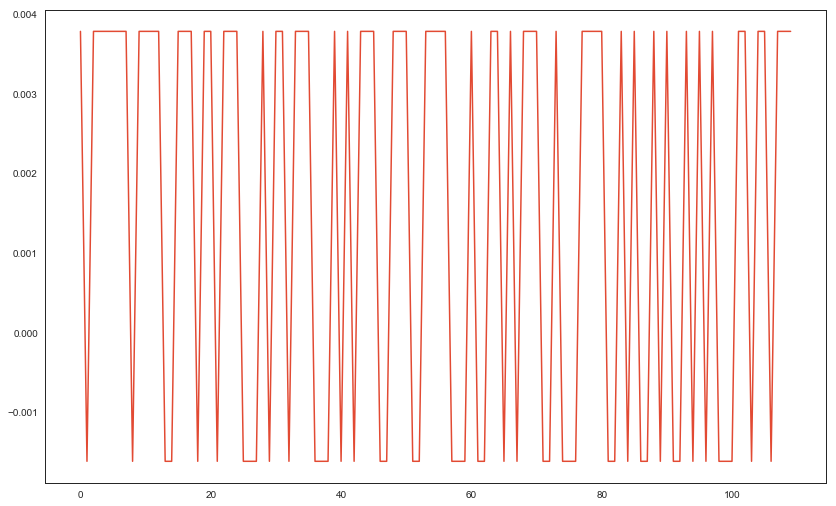

In [854]:
pred = linmodel.predict(df4.replace(mapper).astype(float).values.reshape(-1,1))
sns.lineplot(y=pred, x=range(len(pred)))

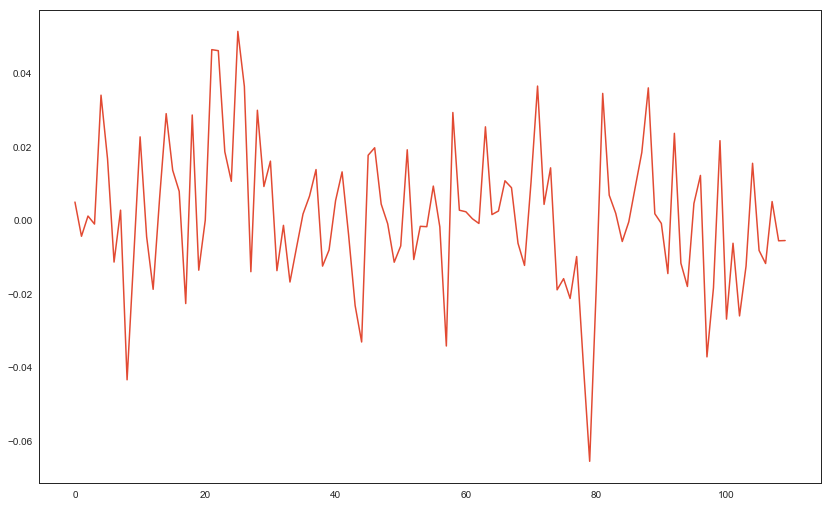

In [855]:
sns.lineplot(y=r_test, x=range(len(pred)))

# Let's not partition into training and test set

In [862]:
my_dict_df.head()

Symbol                                         transcript  \
0    MMM  uld now like to turn the call over to Bruce Je...   
1    ABT   the exception of any participant's questions ...   
2   ABBV  uld now like to introduce Ms. Liz Shea, Vice P...   
3   ABMD  uld now like to introduce your host for today'...   
4    ACN  uld now like to turn the conference over to ou...   

                   sector                     subindustry  
0             Industrials        Industrial Conglomerates  
1             Health Care           Health Care Equipment  
2             Health Care                 Pharmaceuticals  
3             Health Care           Health Care Equipment  
4  Information Technology  IT Consulting & Other Services

In [863]:
vectorizer = CountVectorizer(max_df=0.25, min_df=0.01,stop_words='english',ngram_range=(1,2))
doc_term_matrix = vectorizer.fit_transform(my_dict_df['transcript'])
vocab_cnt = pd.Series(vectorizer.vocabulary_)
#vocab_cnt_adj = vocab_cnt.drop('uld')
vocab_cnt.sort_values(ascending=False).head()

zero         7065
younger      7064
young        7063
york city    7062
york         7061
dtype: int64

In [864]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

chunk_matrix = vectorizer.fit_transform(my_dict_df['transcript'])
words = vectorizer.get_feature_names()

chunk_matrix

<481x3252 sparse matrix of type '<class 'numpy.int64'>'
	with 65508 stored elements in Compressed Sparse Row format>

In [865]:
n_components = 11
topic_labels = [f'Topic{i}' for i in range(1, n_components+1)]

In [866]:
lda_base_chunk = LatentDirichletAllocation(n_components=n_components,
                                     learning_method='online',
                                     max_iter=100)
lda_base_chunk.fit(chunk_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=11, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [867]:
joblib.dump(lda_base_chunk, 'lda_base_chunk.pkl')

['lda_base_chunk.pkl']

In [868]:
lda_base_chunk

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=11, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [871]:
chunk_preds = lda_base_chunk.transform(chunk_matrix)
chunk_preds.shape

(481, 11)

In [872]:
chunk_eval = pd.DataFrame(chunk_preds, columns=topic_labels, index=my_dict_df['sector'])
chunk_eval.head()

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  \
sector                                                                   
Industrials               0.30    0.00    0.00    0.36    0.00    0.00   
Health Care               0.00    0.00    0.32    0.35    0.32    0.00   
Health Care               0.00    0.00    0.00    0.75    0.25    0.00   
Health Care               0.00    0.00    0.00    0.53    0.23    0.00   
Information Technology    0.52    0.00    0.00    0.47    0.00    0.00   

                        Topic7  Topic8  Topic9  Topic10  Topic11  
sector                                                            
Industrials               0.33    0.00    0.00     0.00     0.00  
Health Care               0.00    0.00    0.00     0.00     0.00  
Health Care               0.00    0.00    0.00     0.00     0.00  
Health Care               0.00    0.00    0.00     0.23     0.00  
Information Technology    0.00    0.00    0.00     0.00     0.00

(481,)

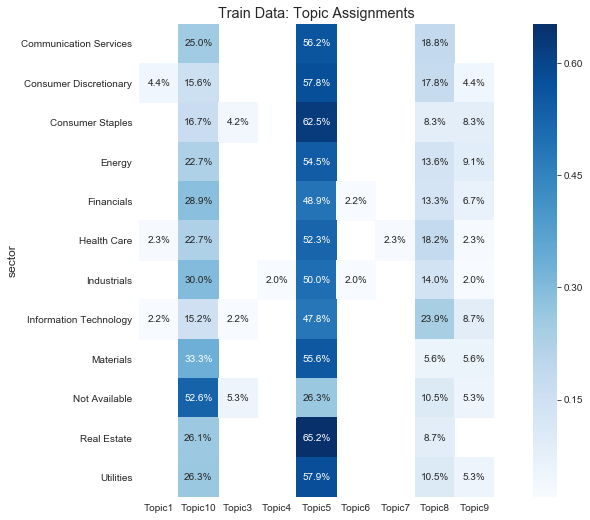

In [878]:
# Assign each document the topic label (from 1 to 11) with max prob
df5 = chunk_eval.groupby(level='sector').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='sector').value_counts(normalize=True).sort_values()
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');
df5.shape

In [881]:
df5.replace(mapper).astype(float).values.reshape(-1,1)

array([[0.4000988 ],
       [0.44455422],
       [0.        ],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.26673253],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.        ],
       [0.13336627],
       [0.35564338],
       [0.13336627],
       [0.        ],
       [0.13336627],
       [0.13336627],
       [0.17782169],
       [0.26673253],
       [0.13336627],
       [0.        ],
       [0.26673253],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.        ],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.35564338],
       [0.        ],
       [0.13336627],
       [0.        ],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.13336627],
       [0.        ],
       [0.13336627],
       [0.        ],
       [0.13336627],
       [0.13336627],
       [0.133

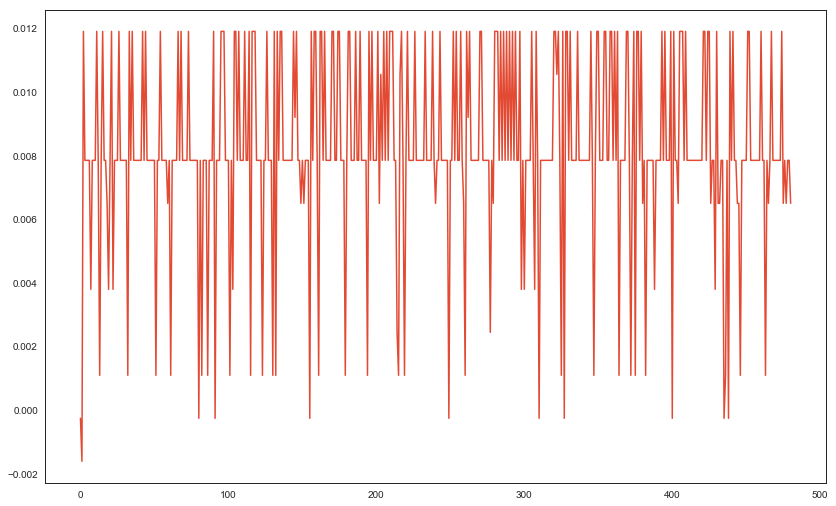

In [882]:
pred_chunk = linmodel.predict(df5.replace(mapper).astype(float).values.reshape(-1,1))
sns.lineplot(y=pred_chunk, x=range(len(pred_chunk)))

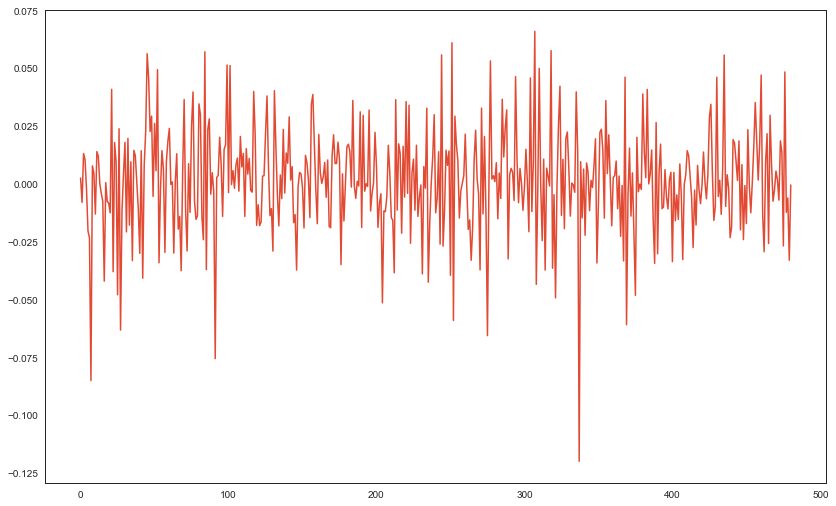

In [884]:
sns.lineplot(y=r, x=range(len(r)))

In [1]:
my_dict_df.shape

NameError: name 'my_dict_df' is not defined

In [893]:
df5.shape

(481,)

In [914]:
lin_base_topic = df5
lin_base_topic
lin_base_topic.index = [x for x in range(481)]

In [956]:
lin_base_df = pd.concat([lin_base_topic,pd.Series(r)],axis=1)
lin_base_df.head()

0     1
0  Topic10  0.00
1  Topic11 -0.01
2   Topic1  0.01
3   Topic4  0.01
4   Topic4 -0.00

In [984]:
for i in range(1,12):
    exec(f"r_topic_{i} = lin_base_df[lin_base_df[0]=='Topic{i}'][1]")
    exec(f"r_topic_{i}_index = lin_base_df[lin_base_df[0]=='Topic{i}'].index")
    exec(f"base_pred_topic_{i} = pred_chunk[r_topic_{i}_index]")


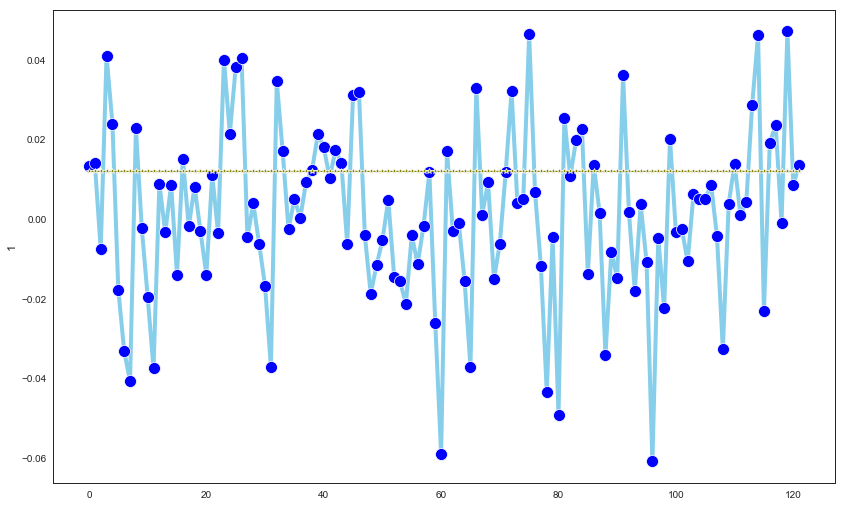

In [958]:

sns.lineplot(x=range(len(y_base_chunk)),y=y_base_chunk, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
sns.lineplot(x=range(len(y_base_chunk)),y=x_base_chunk, marker='*', color='olive', linewidth=2)


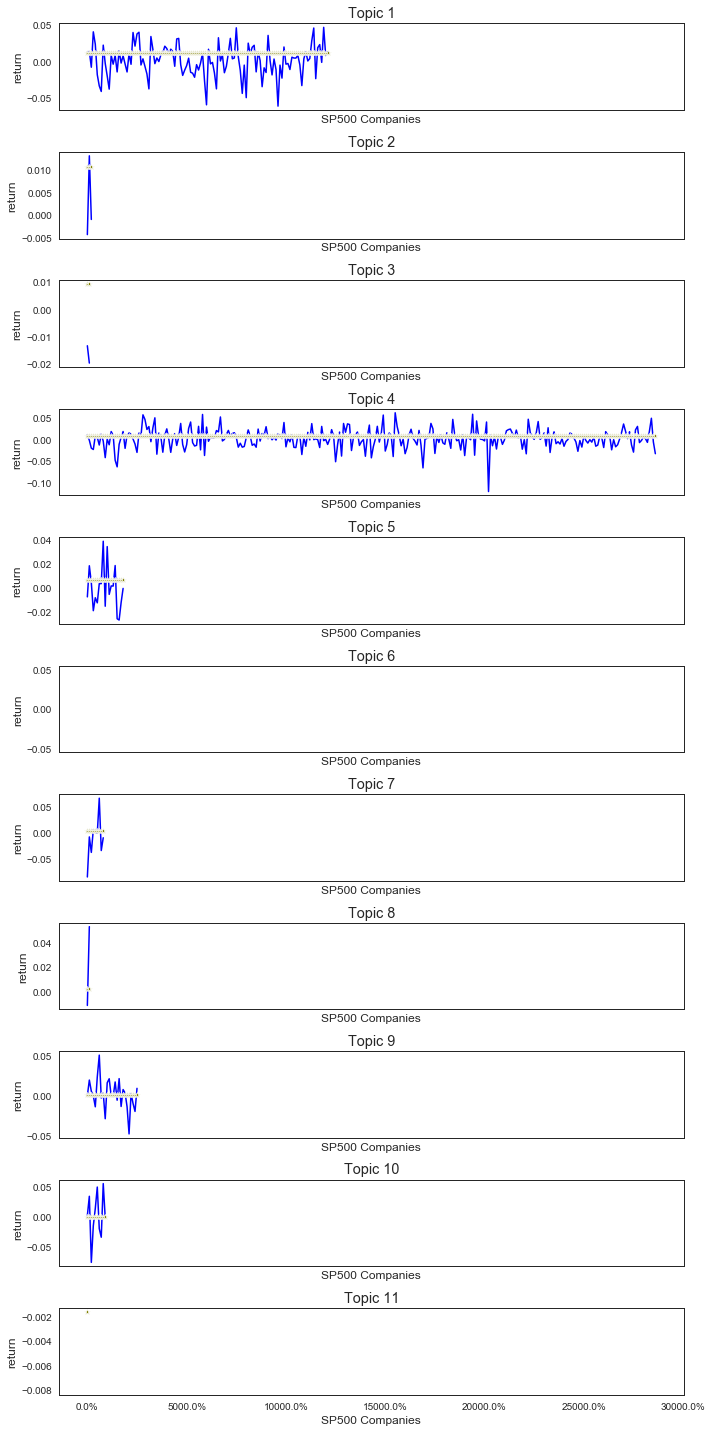

In [1210]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=11,sharex=True, figsize=(10, 20))
for i in range(1,12):
    exec(f'sns.lineplot(y=r_topic_{i},x=range(len(r_topic_{i})), ax=axes[i-1],color="b")')
    exec(f"sns.lineplot(x=range(len(r_topic_{i})),y=base_pred_topic_{i}, marker='*', color='olive', linewidth=2,ax=axes[i-1])")
    axes[i-1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    axes[i-1].set_xlabel('SP500 Companies')
    axes[i-1].set_ylabel('return')
    exec(f"axes[i-1].set_title('Topic {i}')")
fig.tight_layout()

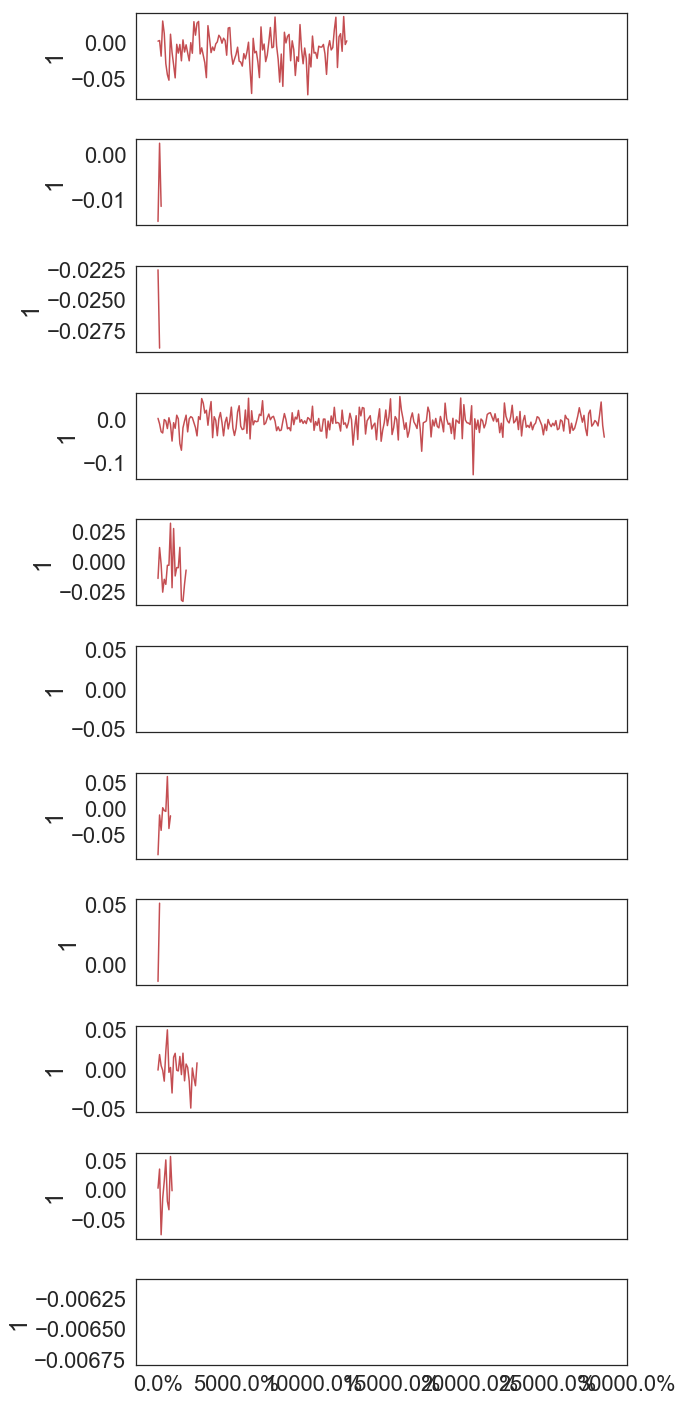

In [1277]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=11,sharex=True, figsize=(10, 20))
for i in range(1,12):
    exec(f'sns.lineplot(y=r_topic_{i}-base_pred_topic_{i},x=range(len(r_topic_{i})), ax=axes[i-1],color="r")')
    axes[i-1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.tight_layout()

In [994]:
url = f'https://api.iextrading.com/1.0/stock/{list(my_dict.keys())[0]}/stats'
other_df = pd.read_json(url,lines=True)
for symbol in list(my_dict.keys())[1:]:
    url= f'https://api.iextrading.com/1.0/stock/{symbol}/stats'
    other_df = pd.concat([other_df,pd.read_json(url,lines=True)])
other_df.head()

EBITDA  EPSSurpriseDollar  EPSSurprisePercent  beta  cash  \
0       0                nan                0.00  1.06     0   
0       0                nan                0.00  1.11     0   
0       0                nan                0.00  1.16     0   
0       0                nan               -2.50  0.28     0   
0       0                nan                6.52  1.12     0   

                       companyName  consensusEPS  day200MovingAvg  \
0                       3M Company          2.50           200.83   
0              Abbott Laboratories          0.61            69.93   
0                      AbbVie Inc.          2.05            85.65   
0                     ABIOMED Inc.          0.80           354.14   
0  Accenture plc Class A (Ireland)          1.84           160.04   

   day30ChangePercent  day50MovingAvg  ...  shortRatio  symbol  ttmEPS  \
0                0.09          208.28  ...        4.44     MMM    9.98   
0               -0.05           77.11  ...        2.56     ABT    2.88   
0                0.01           79.36  ...        3.75    ABBV    7.91   
0               -0.21          318.54  ...         nan    ABMD    2.72   
0                0.11          165.49  ...        2.20     ACN    6.91   

   week52change week52high  week52low  year1ChangePercent  year2ChangePercent  \
0          1.61     221.01     176.87                0.02                0.20   
0         24.00      80.74      56.81                0.24                0.75   
0        -12.74     107.25      75.77               -0.13                0.31   
0        -17.39     459.75     250.30               -0.17                1.08   
0         18.05     180.00     132.63                0.18                0.60   

   year5ChangePercent  ytdChangePercent  
0                0.78              0.15  
0                1.09              0.06  
0                0.90             -0.10  
0                9.08             -0.19  
0                1.48              0.28  

[5 rows x 50 columns]

In [996]:
joblib.dump(other_df, 'ohter_df.pkl')

['ohter_df.pkl']

In [1018]:
other_lookup_df = other_df.set_index('symbol')
other_lookup_df = (other_lookup_df[['returnOnEquity','EBITDA','revenue',
                                'grossProfit','ttmEPS','ttmEPS','revenuePerShare',
                                'revenuePerEmployee','returnOnAssets']])
print(other_lookup_df.shape)
other_lookup_df.head()

(481, 9)


returnOnEquity  EBITDA  revenue  grossProfit  ttmEPS  ttmEPS  \
symbol                                                                 
MMM              50.34       0        0            0    9.98    9.98   
ABT               7.75       0        0            0    2.88    2.88   
ABBV           -317.20       0        0            0    7.91    7.91   
ABMD             30.46       0        0            0    2.72    2.72   
ACN              39.98       0        0            0    6.91    6.91   

        revenuePerShare  revenuePerEmployee  returnOnAssets  
symbol                                                       
MMM                   0                0.00           14.43  
ABT                   0                0.00            3.32  
ABBV                  0                0.00            8.90  
ABMD                  0                0.00           26.96  
ACN                   0                0.00           18.26

In [1021]:
joblib.dump(other_lookup_df, 'other_lookup_df.pkl')

['other_lookup_df.pkl']

In [1035]:
Reg_df_notopic = pd.concat([other_lookup_df,pd.Series(r,index = other_lookup_df.index,dtype=float,name='return')],axis=1)
Reg_df_notopic.head()

returnOnEquity  EBITDA  revenue  grossProfit  ttmEPS  ttmEPS  \
symbol                                                                 
MMM              50.34       0        0            0    9.98    9.98   
ABT               7.75       0        0            0    2.88    2.88   
ABBV           -317.20       0        0            0    7.91    7.91   
ABMD             30.46       0        0            0    2.72    2.72   
ACN              39.98       0        0            0    6.91    6.91   

        revenuePerShare  revenuePerEmployee  returnOnAssets  return  
symbol                                                               
MMM                   0                0.00           14.43    0.00  
ABT                   0                0.00            3.32   -0.01  
ABBV                  0                0.00            8.90    0.01  
ABMD                  0                0.00           26.96    0.01  
ACN                   0                0.00           18.26   -0.00

In [1046]:
Reg_df_notopic_dropna = Reg_df_notopic.dropna()
x_Reg_notopic_dropna = Reg_df_notopic_dropna.iloc[:,:-1].values
x_Reg_notopic_dropna

array([[  50.34,    0.  ,    0.  , ...,    0.  ,    0.  ,   14.43],
       [   7.75,    0.  ,    0.  , ...,    0.  ,    0.  ,    3.32],
       [-317.2 ,    0.  ,    0.  , ...,    0.  ,    0.  ,    8.9 ],
       ...,
       [  -3.31,    0.  ,    0.  , ...,    0.  ,    0.  ,   -1.52],
       [  12.2 ,    0.  ,    0.  , ...,    0.  ,    0.  ,    1.28],
       [  72.21,    0.  ,    0.  , ...,    0.  ,    0.  ,   14.75]])

In [1050]:
y_Reg_notopic_dropna = Reg_df_notopic_dropna.iloc[:,-1].values
y_Reg_notopic_dropna.reshape(-1,1)

array([[ 2.43861170e-03],
       [-8.07117796e-03],
       [ 1.30775537e-02],
       [ 1.05114476e-02],
       [-2.20056899e-03],
       [-2.03585748e-02],
       [-2.34446103e-02],
       [-8.51063830e-02],
       [ 7.71007982e-03],
       [ 4.48630513e-03],
       [-1.31106745e-02],
       [ 1.39084588e-02],
       [ 1.18953384e-02],
       [-6.19780092e-05],
       [-4.13507926e-03],
       [-7.64718448e-03],
       [-4.20977384e-02],
       [ 4.90978376e-04],
       [-7.59644930e-03],
       [-1.25743349e-02],
       [ 4.08201993e-02],
       [ 1.77967954e-02],
       [ 9.37994416e-03],
       [-4.79621455e-02],
       [ 2.37768775e-02],
       [-6.32635545e-02],
       [-1.15008961e-02],
       [ 4.31501800e-03],
       [-2.08005846e-02],
       [-1.79061245e-02],
       [ 9.49888993e-03],
       [-3.32039066e-02],
       [ 1.44499734e-02],
       [ 1.21165555e-02],
       [ 5.70573764e-04],
       [-1.08071866e-02],
       [-3.00768816e-02],
       [-4.08175570e-02],
       [ 7.7

In [1053]:
lin_notopic_dropna = LinearRegression()
lin_notopic_dropna.fit(x_Reg_notopic_dropna,y_Reg_notopic_dropna.reshape(-1,1))
lin_notopic_dropna.score(x_Reg_notopic_dropna,y_Reg_notopic_dropna.reshape(-1,1))

0.012116013885610346

In [1054]:
lin_notopic_dropna.score(x_Reg_notopic_dropna,y_Reg_notopic_dropna.reshape(-1,1))

0.012116013885610346

In [1123]:
lin_notopic_dropna_pipe = make_pipeline(StandardScaler(),PCA(),LinearRegression())
lin_notopic_dropna_pipe.fit(x_Reg_notopic_dropna,y_Reg_notopic_dropna.reshape(-1,1))
y_pred_lin_notopic_dropna=lin_notopic_dropna_pipe.predict(x_Reg_notopic_dropna)
lin_notopic_dropna_pipe.score(x_Reg_notopic_dropna,y_Reg_notopic_dropna.reshape(-1,1))

0.012116013885610346

Text(0.5, 0, 'SP500 Companies')

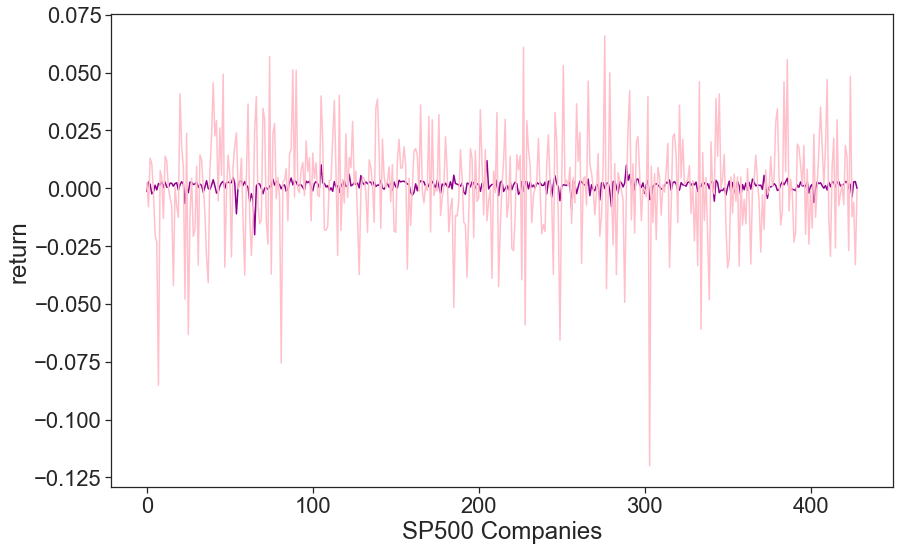

In [1269]:
sns.set(font_scale=2)
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 100, "ytick.major.size": 0.05})

fig = sns.lineplot(x=range(len(y_pred_lin_notopic_dropna)),y=y_pred_lin_notopic_dropna.reshape(-1,),color='darkmagenta')
sns.lineplot(x=range(len(y_pred_lin_notopic_dropna)),y=y_Reg_notopic_dropna.reshape(-1,),color='pink')
fig.set_ylabel('return')
fig.set_xlabel('SP500 Companies')


In [1103]:
df5.index= Reg_df_notopic.index
Reg_df_topic= pd.concat([Reg_df_notopic,pd.Series(df5,name='topic')],axis=1)
Reg_df_topic.head()

returnOnEquity  EBITDA  revenue  grossProfit  ttmEPS  ttmEPS  \
symbol                                                                 
MMM              50.34       0        0            0    9.98    9.98   
ABT               7.75       0        0            0    2.88    2.88   
ABBV           -317.20       0        0            0    7.91    7.91   
ABMD             30.46       0        0            0    2.72    2.72   
ACN              39.98       0        0            0    6.91    6.91   

        revenuePerShare  revenuePerEmployee  returnOnAssets  return    topic  
symbol                                                                        
MMM                   0                0.00           14.43    0.00  Topic10  
ABT                   0                0.00            3.32   -0.01  Topic11  
ABBV                  0                0.00            8.90    0.01   Topic1  
ABMD                  0                0.00           26.96    0.01   Topic4  
ACN                   0                0.00           18.26   -0.00   Topic4

In [1106]:

mapper2 ={}
for i in range(11):
    exec(f'mapper2["Topic{i+1}"]=i')
mapper2

{'Topic1': 0,
 'Topic2': 1,
 'Topic3': 2,
 'Topic4': 3,
 'Topic5': 4,
 'Topic6': 5,
 'Topic7': 6,
 'Topic8': 7,
 'Topic9': 8,
 'Topic10': 9,
 'Topic11': 10}

In [1130]:

Reg_df_topic= pd.concat([Reg_df_topic,pd.Series(df5.replace(mapper2),name='topic_ord')],axis=1)
Reg_df_topic.info()


<class 'pandas.core.frame.DataFrame'>
Index: 481 entries, MMM to ZTS
Data columns (total 13 columns):
returnOnEquity        430 non-null float64
EBITDA                481 non-null int64
revenue               481 non-null int64
grossProfit           481 non-null int64
ttmEPS                481 non-null float64
ttmEPS                481 non-null float64
revenuePerShare       481 non-null int64
revenuePerEmployee    431 non-null float64
returnOnAssets        429 non-null float64
return                481 non-null float64
topic                 481 non-null object
topic_ord             481 non-null int64
topic_ord             481 non-null int64
dtypes: float64(6), int64(6), object(1)
memory usage: 72.6+ KB


In [1134]:
x_Reg_topic_dropna = pd.concat([Reg_df_topic.loc[:,:'returnOnAssets'],Reg_df_topic.loc[:,'topic_ord']],axis=1)
x_Reg_topic_dropna = x_Reg_topic_dropna.dropna().values
x_Reg_topic_dropna.shape

(429, 11)

In [1135]:
y_Reg_topic_dropna = y_Reg_notopic_dropna
y_Reg_topic_dropna.shape

(429,)

In [1191]:
lin_topic_dropna_pipe = make_pipeline(StandardScaler(),LinearRegression())
lin_topic_dropna_pipe.fit(x_Reg_topic_dropna,y_Reg_topic_dropna.reshape(-1,1))
y_pred_lin_topic_dropna=lin_topic_dropna_pipe.predict(x_Reg_topic_dropna)
lin_topic_dropna_pipe.score(x_Reg_topic_dropna,y_Reg_topic_dropna.reshape(-1,1))

0.012380276406305013

Text(0.5, 0, 'SP500 Companies')

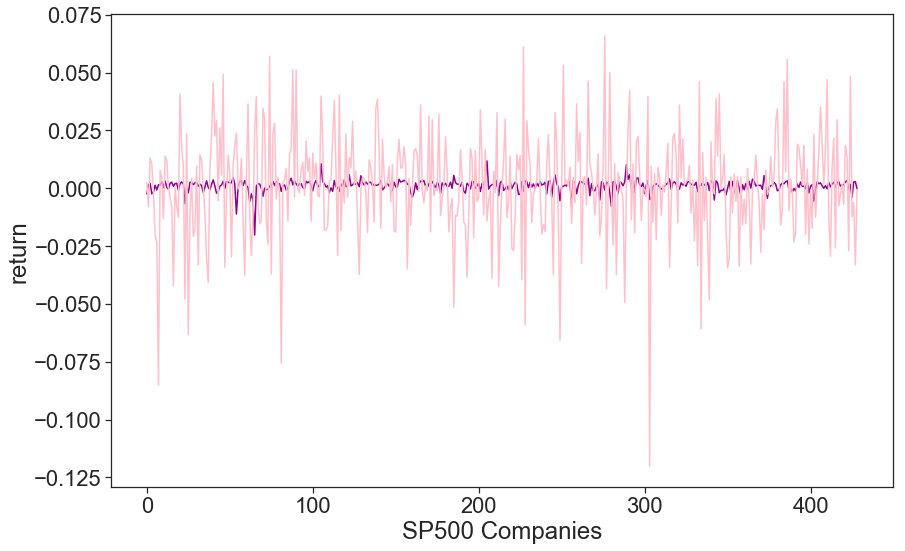

In [1293]:
sns.set(font_scale=2)
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 100, "ytick.major.size": 0.5})
fig2=sns.lineplot(x=range(len(y_pred_lin_topic_dropna)),y=y_pred_lin_topic_dropna.reshape(-1,),color='darkmagenta')
sns.lineplot(x=range(len(y_pred_lin_topic_dropna)),y=y_Reg_topic_dropna.reshape(-1,), color='pink')

fig2.set_ylabel('return')
fig2.set_xlabel('SP500 Companies')

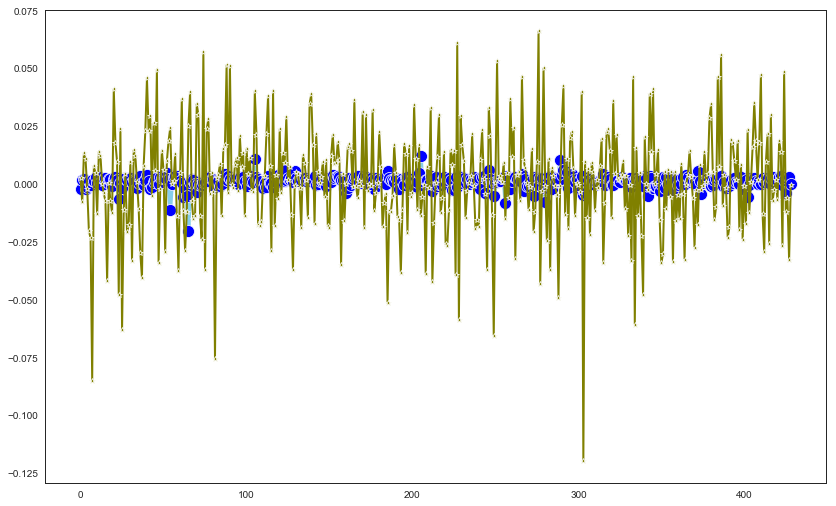

In [1193]:
sns.lineplot(x=range(len(y_pred_lin_topic_dropna)),y=y_pred_lin_topic_dropna.reshape(-1,), marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
sns.lineplot(x=range(len(y_pred_lin_topic_dropna)),y=y_Reg_topic_dropna.reshape(-1,), marker='*', color='olive', linewidth=2)

In [1194]:
for i in range(1,12):
    exec(f"Reg_df_topic=Reg_df_topic.dropna()")
    exec(f"r_topic_other_{i} = Reg_df_topic[Reg_df_topic['topic']=='Topic{i}']['return']")
    exec(f"r_topic_other_{i}_idx = Reg_df_topic[Reg_df_topic['topic']=='Topic{i}'].index")


In [1195]:
r_topic_other_1_idx

Int64Index([  2,  11,  15,  20,  24,  29,  31,  37,  39,  48,
            ...
            376, 377, 378, 379, 384, 390, 392, 402, 410, 422],
           dtype='int64', length=110)

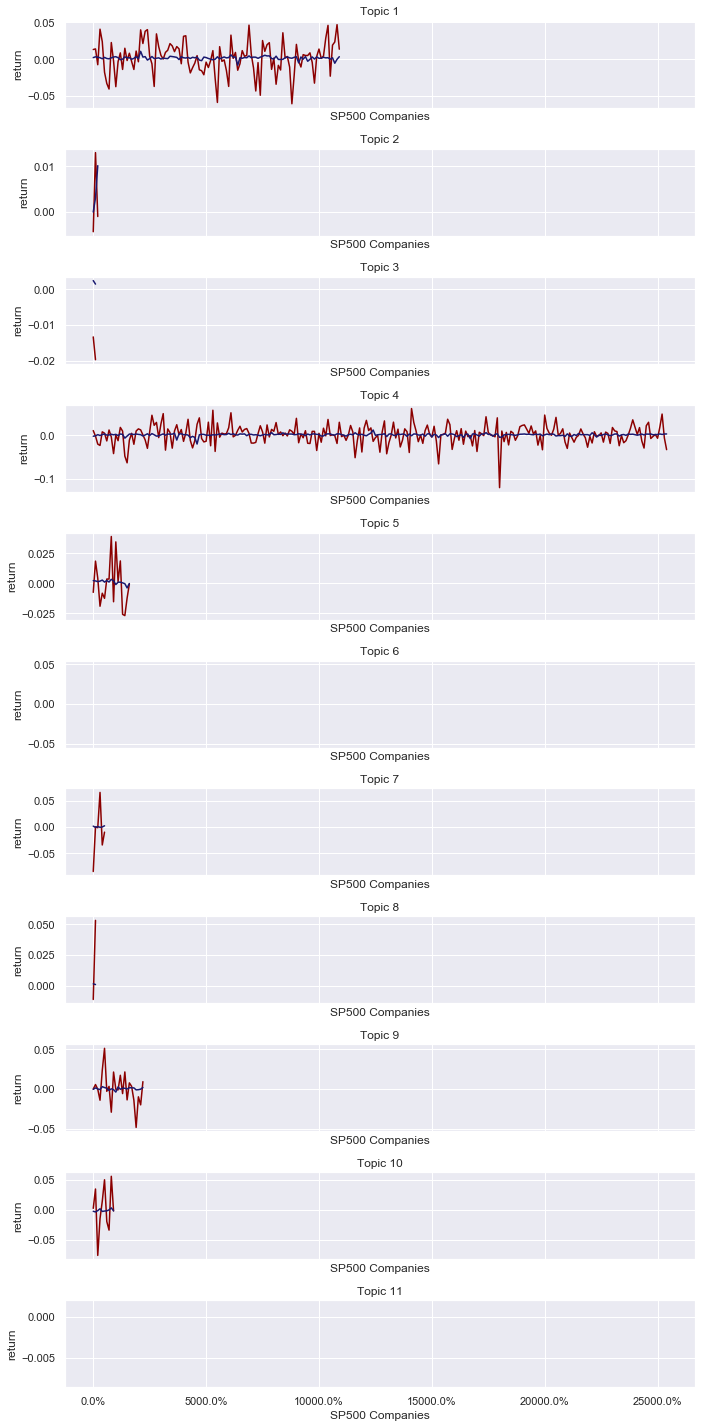

In [1300]:

sns.set_style("white")
sns.set(font_scale=1)
fig, axes = plt.subplots(nrows=11,sharex=True, figsize=(10, 20))
for i in range(1,12):
    exec(f'sns.lineplot(y=r_topic_other_{i},x=range(len(r_topic_other_{i})), ax=axes[i-1],color="darkred")')
    exec(f"sns.lineplot(x=range(len(r_topic_other_{i})),y=y_pred_lin_topic_dropna[r_topic_other_{i}_idx].reshape(-1,), color='midnightblue',ax=axes[i-1])")
    axes[i-1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    axes[i-1].set_xlabel('SP500 Companies')
    exec(f"axes[{i}-1].set_title('Topic {i}')")
fig.tight_layout()


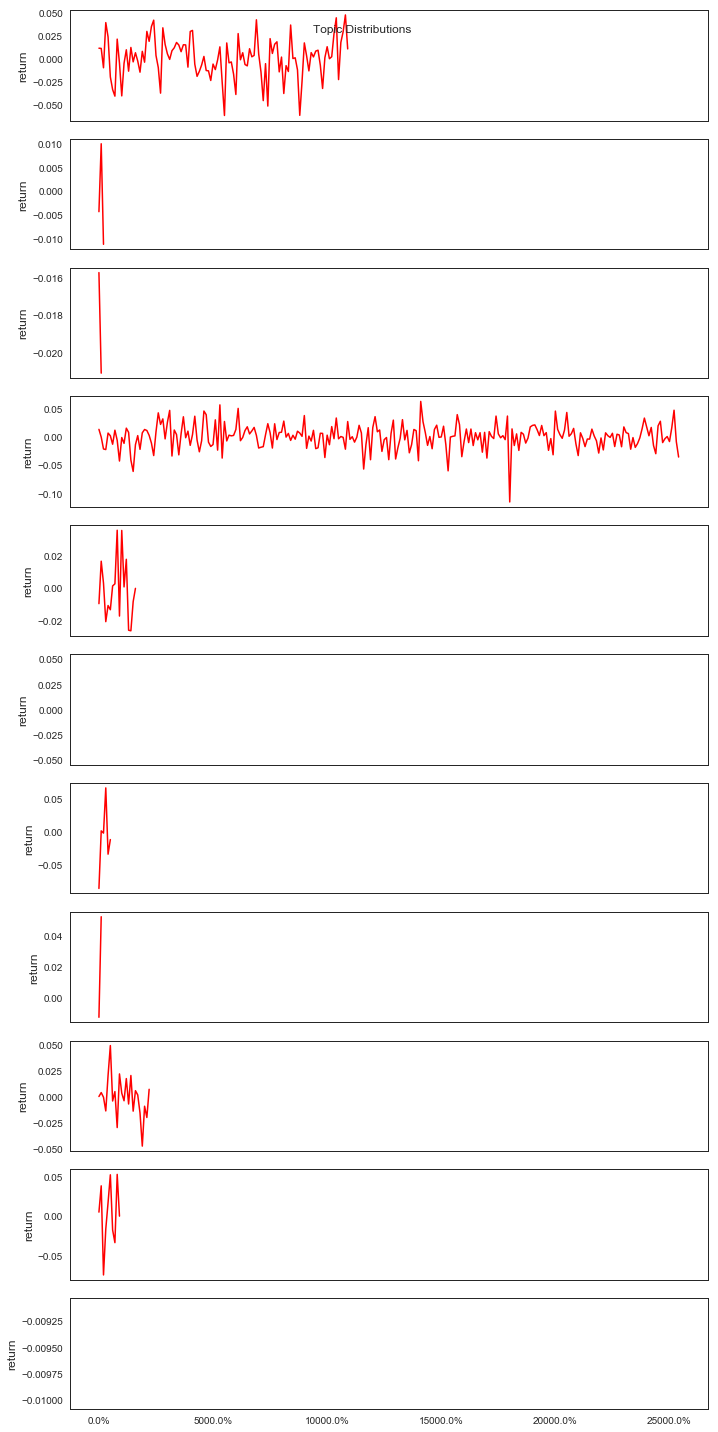

In [1198]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=11,sharex=True, figsize=(10, 20))
for i in range(1,12):
    exec(f'sns.lineplot(y=r_topic_other_{i}-y_pred_lin_topic_dropna[r_topic_other_{i}_idx].reshape(-1,),x=range(len(r_topic_other_{i})), ax=axes[i-1],color="r")')
    
    axes[i-1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

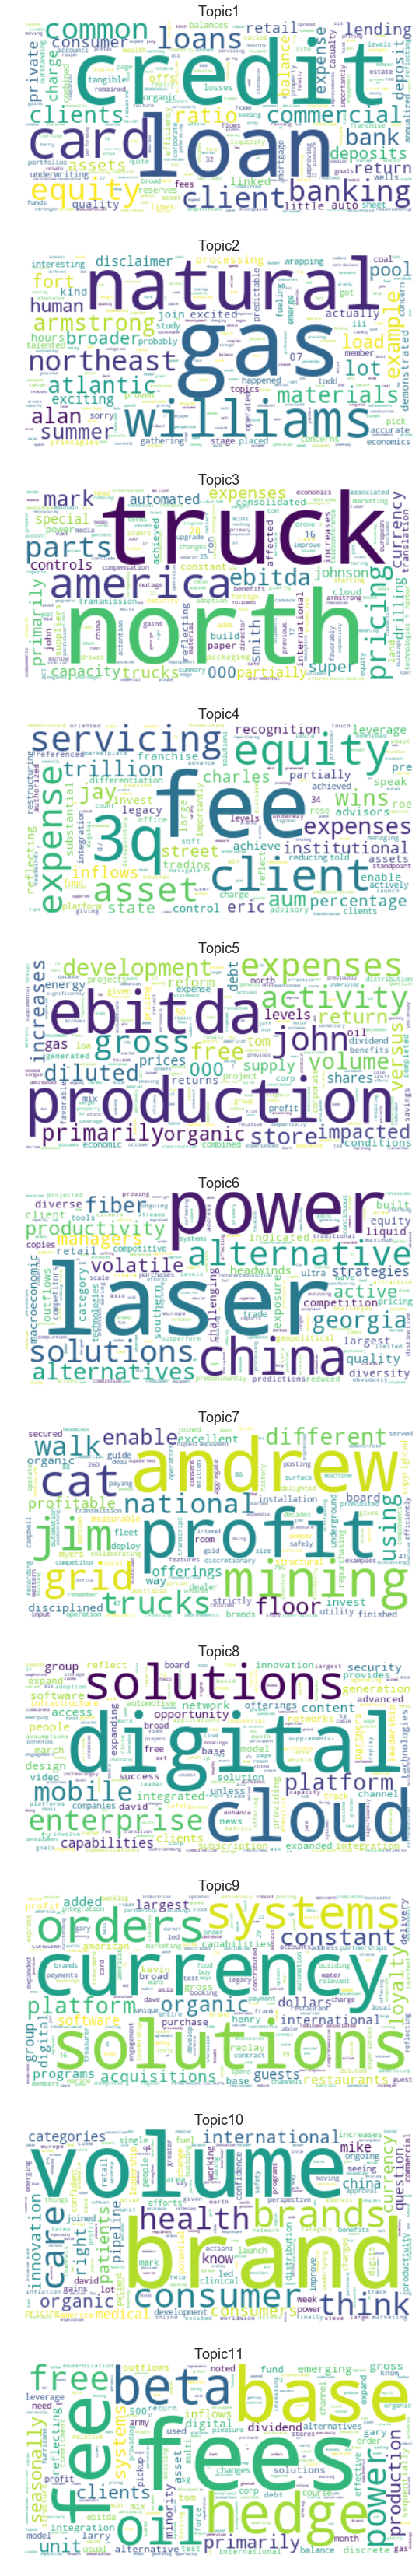

In [1202]:
w = WordCloud(background_color="white")
fig, axes = plt.subplots(nrows=11, figsize=(30, 60))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

In [1204]:
dir(axes[i-1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbox',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_m

In [1206]:
axes[i-1].axis()

(-6.050000000000001, 127.05, -0.06631440230186245, 0.05237322749735205)